# Homework #6: Burgers' Equation
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 3/21/2020|

In this notebook, we will use the upwind numerical integration methods to solve Burgers' equation for _shock waves_ and plot the results.

## Burgers' Equation for Shock Waves

We can describe the motion of fluids via the _continuity equation_ (conservation of mass):

\begin{align}
\dfrac{\partial\rho(\mathbf{x},t)}{\partial t} + \boldsymbol{\nabla} \cdot \mathbf{j} = 0, \quad \mathbf{j} \equiv \rho \mathbf{v}(\mathbf{x},t),
\tag{1}
\end{align}

where $\rho(\mathbf{x},t)$ is the mass density, $\mathbf{v}(\mathbf{x},t)$ is the velocity of the fluid, and their product $\mathbf{j} \equiv \rho \mathbf{v}$ is the mass current.

For a 1D flow along the $x$-axis, with constant velocity $v$, Eq. 1 simplifies to

\begin{align}
\dfrac{\partial\rho}{\partial t} + v\dfrac{\partial\rho}{\partial x} = 0,
\tag{2}
\end{align}

known as the _advection equation_. Since all points along an advecting signal move at the same velocity, this kind of wave maintains a constant shape. However, if the relative speed of parts of the wave depends on its local amplitude (e.g., higher parts moving faster than lower parts), then the wave will change shape over time. In this scenario, a smooth wave (e.g., sinusoidal) will develop a sharp leading edge, becoming a _shock wave_.

If, in Eq. 2, we substitute $\rho = U$, for any arbitrary signal, and make the wave speed proportional to the amplitude of the wave, i.e., $v = \epsilon U$, we arrive at

\begin{align}
\dfrac{\partial U}{\partial t} + \epsilon U\dfrac{\partial U}{\partial x} = 0,
\tag{3}
\end{align}

or ___Burgers' equation___. We can write Eq. 3 in its _conservative form_:

\begin{align}
\dfrac{\partial U}{\partial t} + \epsilon \dfrac{\partial (U^2/2)}{\partial x} = 0,
\tag{4}
\end{align}

where an application of the chain-rule in the second term yields Eq. 3.

## 1. Upwind Method

Let's use the _upwind_ method to solve Burgers' equation. Assuming the overall flow is only in one direction, depending on the sign of $\epsilon$, the spatial derivative can be approximated with only a one-sided difference. Using information from upstream, we find

\begin{align}
\epsilon\dfrac{\partial}{\partial x}\left(\dfrac{U^2}{2}\right) =
\begin{cases}
\dfrac{(U_{j}^n)^2 - (U_{j-1}^n)^2}{2\Delta x}, \quad \epsilon = 1\\
\dfrac{(U_{j+1}^n)^2 - (U_{j}^n)^2}{2\Delta x}, \quad \epsilon = -1.
\end{cases}
\tag{5}
\end{align}

Thus, from Eq. 4,

\begin{align}
\dfrac{\partial U}{\partial t} &= \dfrac{U_{j}^{n+1}-U_{j}^n}{\Delta t} = -\epsilon \dfrac{\partial}{\partial x}\left(\dfrac{U^2}{2}\right).
\tag{6}
\end{align}

Solving for the future state after one timestep,

\begin{align}
U_j^{n+1} = 
\begin{cases}
U_j^n - \dfrac{\beta}{2}\left[(U_{j}^n)^2 - (U_{j-1}^n)^2\right], \quad \epsilon = 1\\
U_j^n - \dfrac{\beta}{2}\left[(U_{j+1}^n)^2 - (U_{j}^n)^2\right], \quad \epsilon = -1,
\end{cases}
\tag{7}
\end{align}

where,

\begin{align}
\beta \equiv |\epsilon| \dfrac{\Delta t}{\Delta x}
\tag{8}
\end{align}

is known as the _Courant-Friedrichs-Lewy_ (CFL) _number_. If the requirement for stability is $\beta < 1$, this implies the following timestep limitation:

\begin{align}
\Delta t < \Delta x, \quad |\epsilon| = 1.
\tag{9}
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def burgers(beta=0.99, periodic=False, wire=True):
    """
    Solve, simulate, and visualize Burgers' equation (Eq. 7).
    
    Parameters
    ----------
    beta : float
        Courant-Friedrichs-Lewy (CFL) number. Must be less
        than one (1) for stability.
        Default set to 0.99 for larger timesteps.
    periodic : bool
        Apply periodic boundary conditions if set to True.
        Default set to False.
    wire : bool
        Draw 3D spectrogram (waterfall plot) as a wireframe,
        as opposed to a continuous surface.
        Default set to True.
    """
    # Setup mesh
    x = np.linspace(xmin, xmax, Nx)
    dx = (xmax - xmin) / (Nx - 1)
    dt = abs(beta) * dx / abs(eps) # CFL condition
    beta = eps * dt / dx      # CFL number

    # Initialize state
    t = 0.0
    U = np.zeros(Nx,)
    U = 0.2 + 0.8 * np.exp(-0.5 * x**2)

    # Prepare 3D output
    tp = [t]
    Up = np.copy(U)

    # Initialize 2D plot
    fig = plt.figure(figsize=(11,6))
    ax = fig.gca()
    ax.plot(x, U, label=r"$t = {:.3G}$".format(t))
    ax.set_title(r'Time Slices', fontsize='xx-large', fontweight='bold')
    ax.set_xlabel(r"Position, $x$", fontsize='large')
    ax.set_ylabel(r"Amplitude, $U(t,x)$", fontsize='large')
    ax.grid()

    # Begin simulation
    tout = t + dtout
    while t < tend:
        Uold = np.copy(U) # Backup previous timestep

        # Solve state at next timestep (Eq. 7)
        if eps > 0:
            for ix in range(1, Nx - 1):
                U[ix] = Uold[ix] - (beta/2)*(Uold[ix]**2 - Uold[ix-1]**2)
        else:
            for ix in range(1, Nx - 1):
                U[ix] = Uold[ix] - (beta/2)*(Uold[ix+1]**2 - Uold[ix]**2)
        if periodic: # Apply periodic boundary conditions
            U[0] = U[-2]
            U[-1] = U[1]
        t += dt

        # Save data every dtout
        if t >= tout:
            plt.plot(x, U, label=r"$t = {:.3G}$".format(t))
            tp.append(t)
            Up = np.vstack((Up, U))
            tout += dtout

    # 3D time evolution plot
    tmesh, xmesh = np.meshgrid(tp, x)
    fig3D = plt.figure(figsize=(11,6))
    ax3D = Axes3D(fig3D)
    if wire:
        ax3D.plot_wireframe(tmesh, xmesh, Up.transpose())
    else:
        ax3D.plot_surface(tmesh, xmesh, Up.transpose())
    ax3D.set_title(r'Spectrogram (Waterfall Plot)', fontsize='xx-large', fontweight='bold')
    ax3D.set_xlabel(r"Time, $t$", fontsize='large')
    ax3D.set_ylabel(r"Position, $x$", fontsize='large')
    ax3D.set_zlabel(r"Amplitude, $U(t,x)$", fontsize='large')
    plt.show()
    
    return tp, x, Up

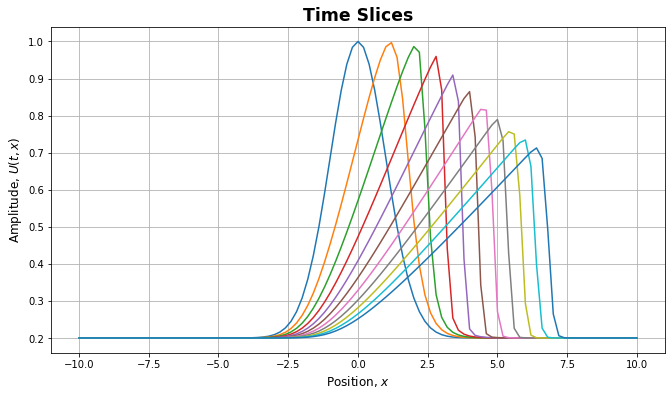

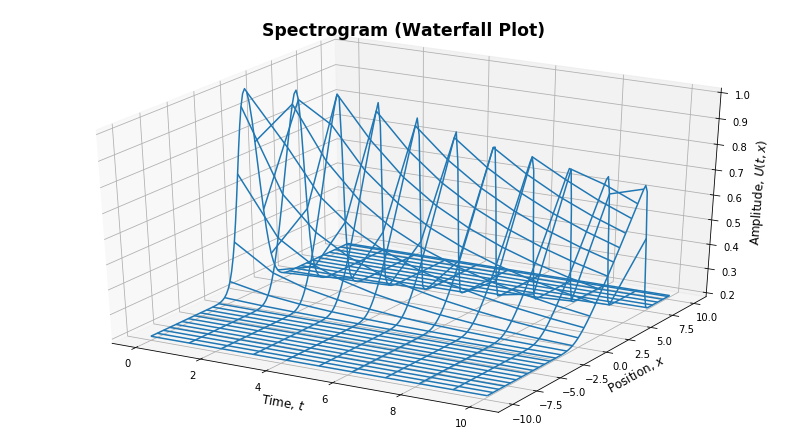

In [2]:
# Model Parameters
eps = 1      # direction of flow (epsilon)
beta = 0.99
xmin = -10.0 # left boundary
xmax = +10.0 # right boundary
Nx = 101     # number of grid points (including boundary)
tend = 10.0  # end time
dtout = 1.0  # time interval for outputs

tp, x, Up = burgers()

## 2. Periodic Boundary Conditions

We can allow the propagating wave to continue _beyond_ the edge of the mesh, looping back to the other end, by employing _periodic boundary conditions_. To do so, we must set the left-most mesh element (at $x=0$) the value of the second to right-most element (at $x=N-1$), and vice versa.

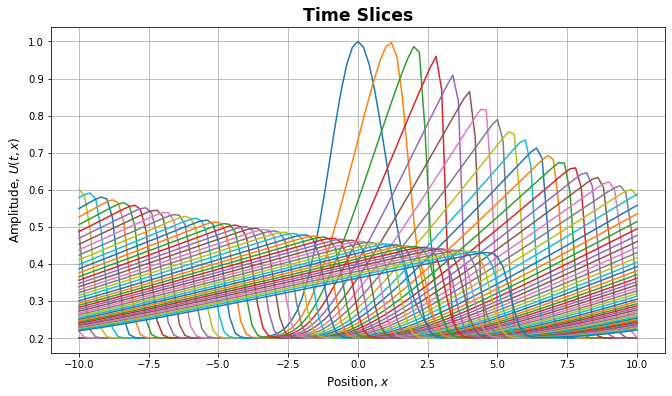

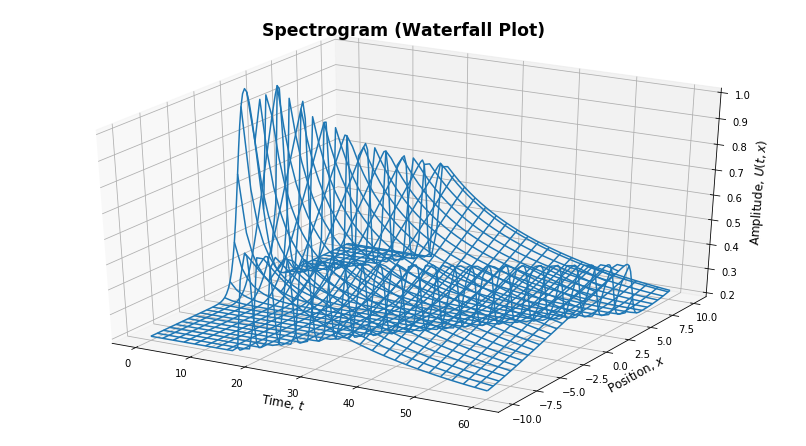

In [3]:
# Model parameters
tend = 60.0 # increase end time

tp, x, Up = burgers(periodic=True)

## 3. Various Grid Sizes

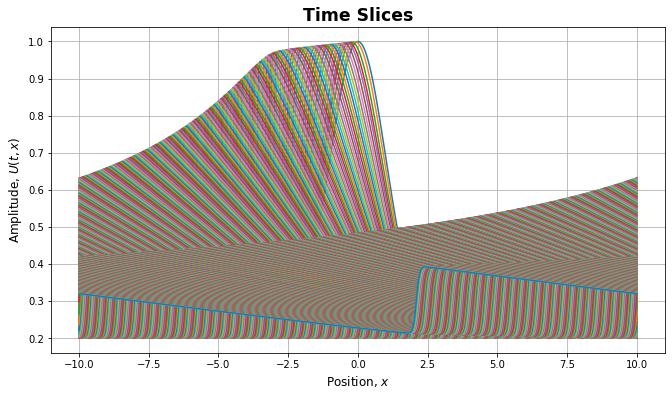

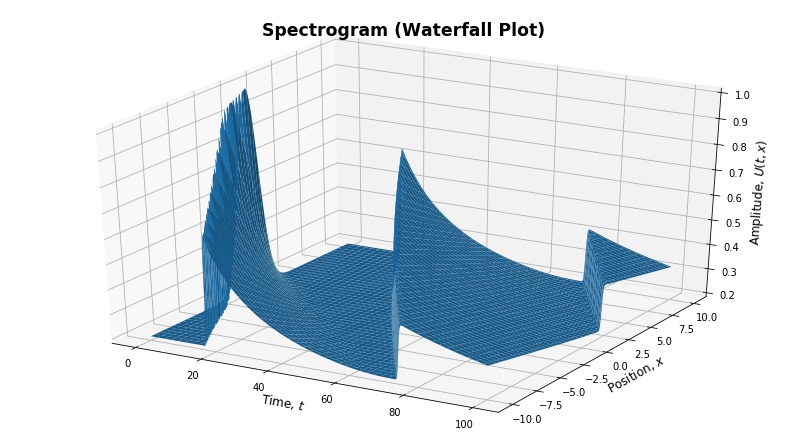

In [4]:
# Model Parameters
eps = -1    # reverse direction
beta = 0.5  # shorter timesteps
Nx = 501   # finer mesh
tend = 100.0
dtout = 0.1   # more frequent outputs

tp, x, Up = burgers(beta, periodic=True, wire=False)

## 4. Animation

If we animate the time-series of states, with each frame a _slice_ along the time-axis above, we can observe the evolution of the shock wave over time.

In [ ]:
from matplotlib import animation
from IPython.display import HTML

total_frames = len(tp)
fig, ax = plt.subplots(figsize=[12.8,7.2]) # 720p resolution
ax.set_xlim(-10, 10)
ax.set_ylim(0.2, 1.05)
ax.set_title(r'Shock Wave Evolution', fontsize='xx-large', fontweight='bold')
ax.set_xlabel(r"Position, $x$", fontsize='large')
ax.set_ylabel(r"Amplitude, $U(t,x)$", fontsize='large')
line, = ax.plot([], [], lw=3)

In [6]:
# initialization function: plot background for each frame
def init():
    line.set_data([], [])
    return line,

# animation function (called sequentially)
def animate(i):
    line.set_data(x, Up[i,:])
    return line,

# Call the animator; blit=True means only re-draw the parts that have changed
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=total_frames, interval=16,
                               blit=True, repeat=True)

# render and embed video
HTML(anim.to_html5_video())